<a href="https://colab.research.google.com/github/rousanka/cv-final-project/blob/main/Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

#from os import path

# nazwa archiwum do dostosowania
# !unzip '/content/drive/MyDrive/archive.zip'

In [16]:
%matloplib inline 

UsageError: Line magic function `%matloplib` not found.


In [2]:
!dir ..\celeba

 Volume in drive D is USER
 Volume Serial Number is 0245-92F8

 Directory of d:\Doc\Priv\ARPDataPL\Notatki\15_Computer_Vision_Projekt\celeba

17/06/2023  11:20    <DIR>          .
17/06/2023  11:20    <DIR>          ..
17/06/2023  10:43    <DIR>          img_align_celeba
01/10/2019  08:52        24�913�339 list_attr_celeba.csv
01/10/2019  08:52         5�390�926 list_bbox_celeba.csv
01/10/2019  08:52         2�836�404 list_eval_partition.csv
01/10/2019  08:52         9�932�092 list_landmarks_align_celeba.csv
               4 File(s)     43�072�761 bytes
               3 Dir(s)  73�470�533�632 bytes free


In [1]:
#!pip install ydata_profiling
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import cv2
import numpy as np
import keras
import tensorflow as tf
import numpy as np
import imgaug.augmenters as iaa

In [28]:
class Dataset:
    def __init__(self,
                 list_attr_celeba_path="../celeba/list_attr_celeba.csv",
                 list_bbox_celeba_path="../celeba/list_bbox_celeba.csv",
                 list_eval_partition_path="../celeba/list_eval_partition.csv",
                 list_landmarks_align_celeba_path="../celeba/list_landmarks_align_celeba.csv",
                 images_path="../celeba/img_align_celeba/img_align_celeba/"
                 ):

        # uncomment
        list_attr_celeba = pd.read_csv(list_attr_celeba_path)
        list_bbox_celeba = pd.read_csv(list_bbox_celeba_path)
        list_eval_partition = pd.read_csv(list_eval_partition_path)
        list_landmarks_align_celeba = pd.read_csv(list_landmarks_align_celeba_path)

        #df = list_attr_celeba.merge(list_bbox_celeba, on='image_id')
        #df = df.merge(list_bbox_celeba, on='image_id')
        #self.df = df.merge(list_eval_partition, on='image_id')
        #self.df = df.merge(list_landmarks_align_celeba, on='image_id')
        self.df = list_attr_celeba.merge(list_eval_partition, on='image_id')
        self.images_path = images_path

    def generate_report(self, report_name='your_report'):
        profile = ProfileReport(self.df, title="Pandas Profiling Report")
        profile.to_file(f"{report_name}.html")

    def show_some_examples(self, attribute: str, positive: bool = True):
        """
        Quick visualization of some examples

        :param attribute: One of boolean attribute:
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
        'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows','Chubby', 'Double_Chin', 'Eyeglasses',
        'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
        'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
        'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
        'Wearing_Necklace', 'Wearing_Necktie', 'Young'
        :type attribute: str
        :param positive: show positive examples or not (negative if false)
        :type positive: boolean
        :return: None
        :rtype: None
        """
        print(self.df.columns)
        if positive:
            exist = 1
        else:
            exist = -1

        df = self.df[self.df[attribute] == exist]
        images = list(df.head(9)['image_id'])
        images = [cv2.imread(self.images_path+path) for path in images]
        horizontal_1 = np.concatenate((images[0], images[1], images[2]), axis=1)
        horizontal_2 = np.concatenate((images[3], images[4], images[5]), axis=1)
        horizontal_3 = np.concatenate((images[6], images[7], images[8]), axis=1)
        vertical = np.concatenate((horizontal_1, horizontal_2, horizontal_3), axis=0)
        # plot first few images
        # define subplot
        plt.subplot(330 + 1 + 0)
        # plot raw pixel data
        plt.imshow(vertical)

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, images, labels, batch_size=8, shuffle=False, augment=False):
        self.labels = labels  # array of labels
        self.images = images  # array of images
        self.batch_size = batch_size  # batch size
        self.shuffle = shuffle  # shuffle bool
        self.augment = augment  # augment data bool
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data for next batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # select data and load images
        labels = np.array([self.labels[k] for k in indexes])
        images = np.array([self.images[k] for k in indexes])

        # preprocess and augment data
        if self.augment:
            images = self.augmentor(images)

        images = images / 255
        return images, labels

    @staticmethod
    def augmentor(images):
        """Apply data augmentation"""
        def sometimes(aug):
            return iaa.Sometimes(0.5, aug)
        list_of_aumgenters = []
        list_of_aumgenters.extend([sometimes(iaa.Crop(px=(1, 16), keep_size=True)),
                                   sometimes(iaa.Fliplr(0.5)),
                                   sometimes(iaa.GaussianBlur(sigma=(0, 3.0)))])

        seq = iaa.Sequential(list_of_aumgenters)

        return seq.augment_images(images)

In [23]:
classification_dataset = Dataset() #definicja klasy Dataset

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'partition'],
      dtype='object')


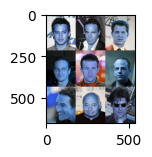

In [6]:
classification_dataset.show_some_examples('5_o_Clock_Shadow') #Podgląd kilku obrazów z tym samym atrybutem

In [ ]:
classification_dataset.generate_report()

In [24]:
classification_dataset.df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'partition'],
      dtype='object')

In [ ]:
classification_dataset.df['partition'].unique()

array([0, 1, 2], dtype=int64)

In [ ]:
classification_dataset.df['partition'][162766:162773]

162766    0
162767    0
162768    0
162769    0
162770    1
162771    1
162772    1
Name: partition, dtype: int64

In [ ]:
classification_dataset.df[:5]

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,0
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,0
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,0
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,0
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,0


In [ ]:
classification_dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202599 entries, 0 to 202598
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [ ]:
classification_dataset.df.replace(0, 5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,5
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,5
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,5
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,5
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,2
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,1,2
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,1,-1,1,1,-1,1,-1,-1,1,2


In [ ]:
# nie zmieniamy w df na 0..1, więc funkcja aktywacji powinna przyjmować -1..1

In [ ]:
# wczytanie listy arrayów ze zdjęć

In [ ]:
len(classification_dataset.df)

202599

In [57]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

for i in range(161000,163200):
#for i in range(len(classification_dataset.df)):
    if classification_dataset.df.loc[i]['partition'] == 0:
        x_train.append(cv2.imread(classification_dataset.images_path + classification_dataset.df.loc[i]['image_id']))
        y_train.append(classification_dataset.df.loc[i]['Attractive'])
    elif classification_dataset.df.loc[i]['partition'] == 1:
        x_test.append(cv2.imread(classification_dataset.images_path + classification_dataset.df.loc[i]['image_id']))
        y_test.append(classification_dataset.df.loc[i]['Attractive'])
    elif classification_dataset.df.loc[i]['partition'] == 2:
        x_val.append(cv2.imread(classification_dataset.images_path + classification_dataset.df.loc[i]['image_id']))
        y_val.append(classification_dataset.df.loc[i]['Attractive'])


        """
        y_train.append(i)
        x_test.append(i)
        y_test.append()
        x_val.append()
        y_val.append(i)
        """



In [43]:
classification_dataset.df.loc[110]['Attractive']

1

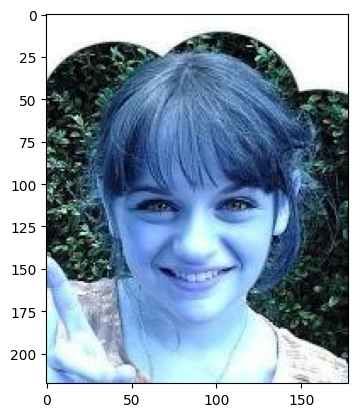

In [44]:
img = cv2.imread(classification_dataset.images_path + '000110.jpg')
plt.imshow(img)

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(512, activation='sigmoid', input_shape=(x_train[0].shape,)))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

TypeError: Dimension value must be integer or None or have an __index__ method, got value '(218, 178, 3)' with type '<class 'tuple'>'

In [62]:
x_train[0].shape

(218, 178, 3)

In [ ]:
history = model.fit(train_x, train_y_one_hot, 
                    batch_size=256, epochs=10, verbose=True, 
                    validation_data=(test_x, test_y_one_hot))